In [2]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '11.0.0'

gfx_version = os.getenv('HSA_OVERRIDE_GFX_VERSION')
print(f"HSA_OVERRIDE_GFX_VERSION is set to: {gfx_version}")

HSA_OVERRIDE_GFX_VERSION is set to: 11.0.0


## RAG Architecture 

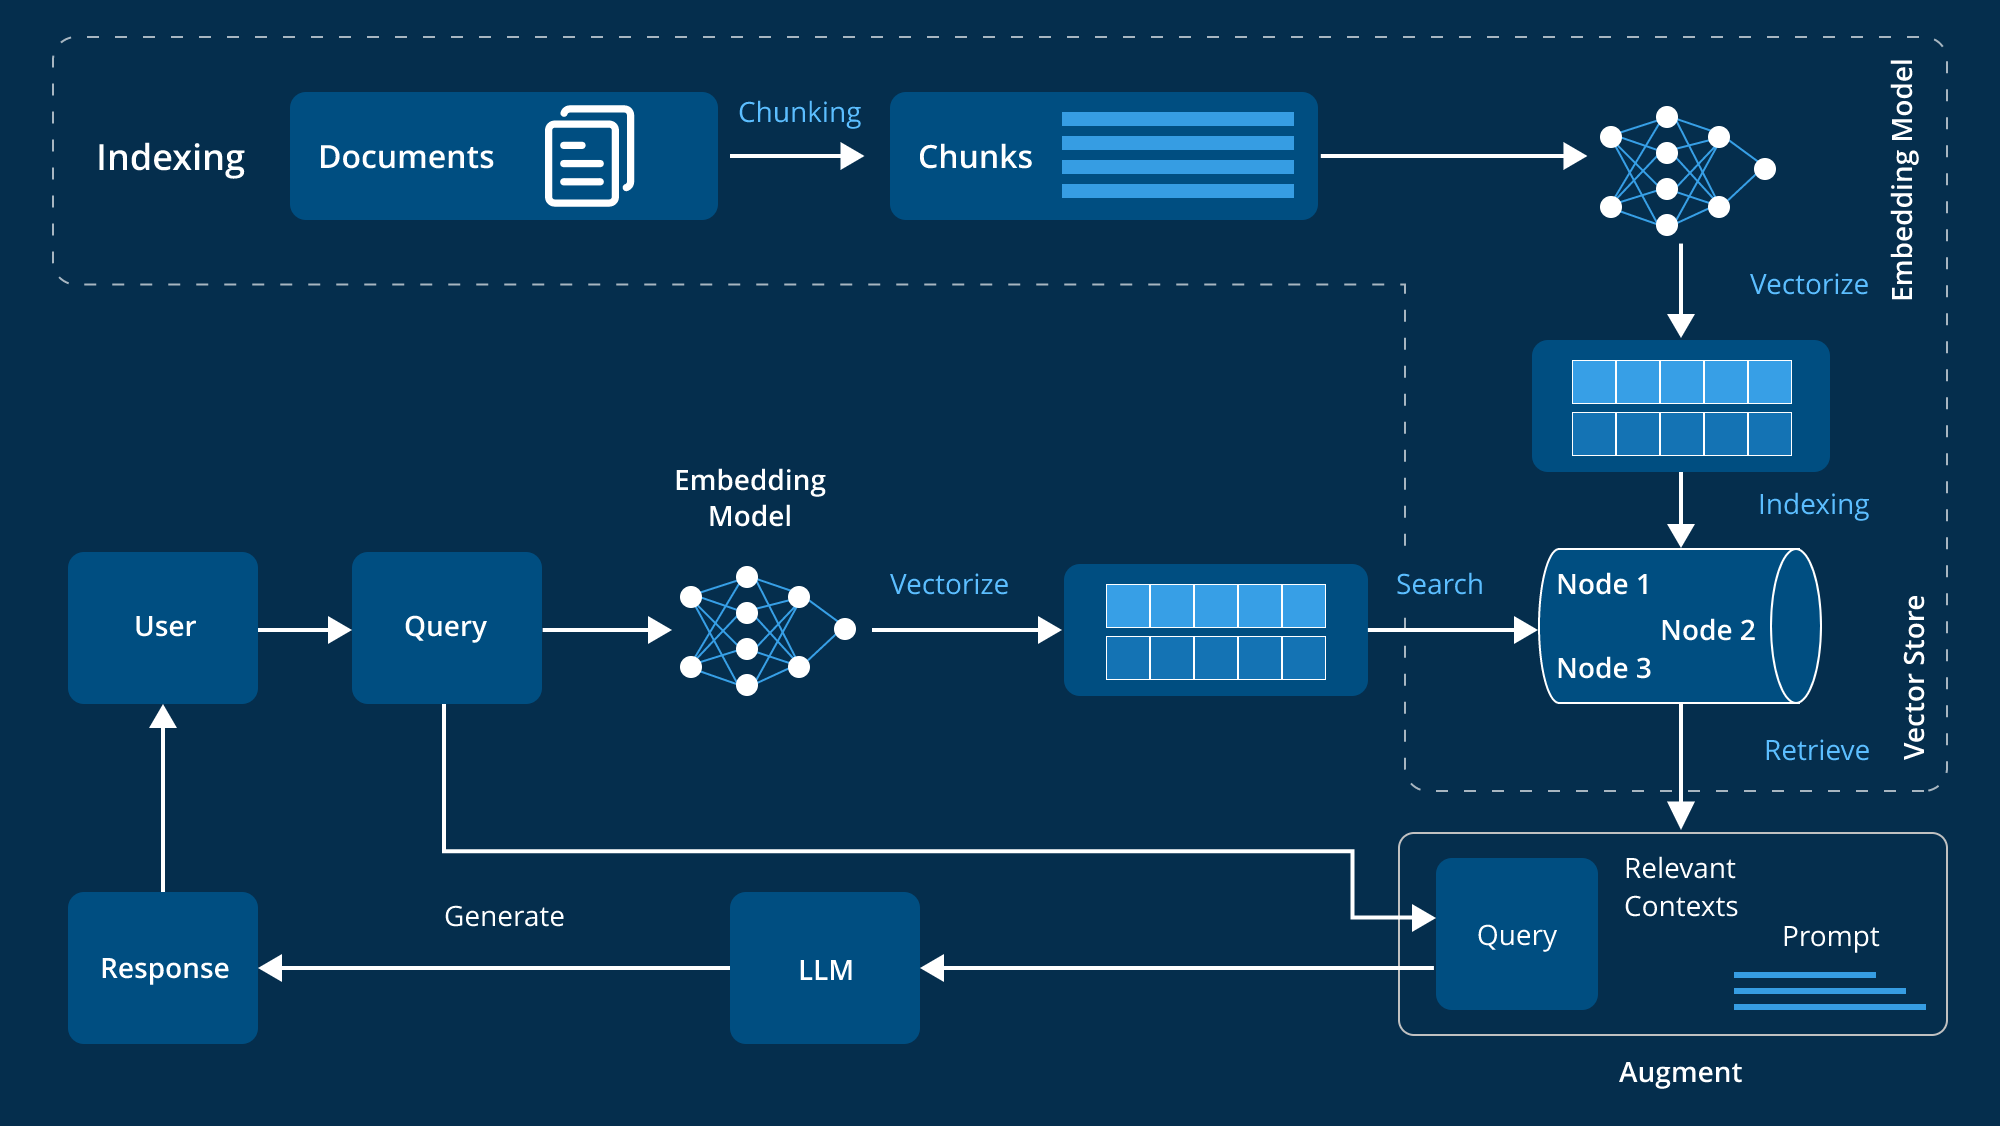

In [4]:
!pip install pypdf  --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [26]:
from pypdf import PdfReader
import textwrap

def load_pdf(path):
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() + "\n"
    return text

In [27]:
import sys
import types

# Ugly fix until paddle ocr is langchain 1.0.0 compatible
# https://github.com/PaddlePaddle/PaddleOCR/issues/16711#issuecomment-3446427004

# Provide old import paths expected by paddlex:
# langchain.docstore.document -> Document
m1 = types.ModuleType("langchain.docstore.document")
from langchain_core.documents import Document  # noqa: E402, I001

m1.Document = Document
sys.modules["langchain.docstore.document"] = m1

# langchain.text_splitter -> RecursiveCharacterTextSplitter
m2 = types.ModuleType("langchain.text_splitter")
from langchain_text_splitters import RecursiveCharacterTextSplitter  # noqa: E402, I001

m2.RecursiveCharacterTextSplitter = RecursiveCharacterTextSplitter  # type: ignore
sys.modules["langchain.text_splitter"] = m2

In [28]:
import os
from langchain_classic.chains import RetrievalQA
from langchain_core.prompts import PromptTemplate
import os
from langchain_milvus import Milvus
from langchain.docstore.document import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.text_splitter import SemanticChunker

In [43]:

class SemanticChunkingONText:

    def __init__(self):
        self.embed_model = HuggingFaceEmbeddings(model_name="jinaai/jina-embeddings-v2-base-en", model_kwargs={'device': 'cpu'}) #

    def chunk(self, text):

        self.documents =  Document(page_content=text, metadata={"source": "local"})
        
        semantic_chunker = SemanticChunker(self.embed_model, breakpoint_threshold_type="gradient")
        semantic_chunks = semantic_chunker.create_documents([self.documents.page_content])
        
        return semantic_chunks


class Vector_Store:
    
    def __init__(self):

        #Load embeddings model
        self.sematic_chunker = SemanticChunkingONText()
        self.embedding_model = self.sematic_chunker.embed_model
        

    def store_data(self, text: str, URI: str):

        docs = self.sematic_chunker.chunk(text)
        #docs = text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=10).split_text(text)

        Milvus.from_documents(
            docs,
            self.embedding_model,
            connection_args={"uri": URI},
        )
        return True

    def retrive_data(self, query:str, URI:str):
        vector_db = Milvus(
            self.embedding_model,
            connection_args={"uri": URI},
        )
        
        docs = vector_db.similarity_search(query)
        
        context = ""
        for doc in docs[:2]:
           context += doc.page_content + " "
        
        return context



In [44]:
URI = "./milvus_demo.db"

text = """
Work-related stress is the response people may have when presented with work demands and pressures that are not matched to their knowledge and abilities and which challenge their ability to cope. Stress occurs in a wide range of work circumstances but is often made worse when employees feel they have little support from supervisors and colleagues, as well as little control over work processes. There is often confusion between pressure or challenge and stress, and sometimes this is used to excuse bad management practice.
Pressure at the workplace is unavoidable due to the demands of the contemporary work environment. Pressure perceived as acceptable by an individual may even keep workers alert, motivated, able to work and learn, depending on the available resources and personal characteristics. However, when that pressure becomes excessive or otherwise unmanageable it leads to stress. Stress can damage an employees' health and the business performance.
Work-related stress can be caused by poor work organization (the way we design jobs and work systems, and the way we manage them), by poor work design (for example, lack of control over work processes), poor management, unsatisfactory working conditions and lack of support from colleagues and supervisors.
Research findings show that the most stressful type of work is that which values excessive demands and pressures that are not matched to workers’ knowledge and abilities, where there is little opportunity to exercise any choice or control, and where there is little support from others.
Workers are less likely to experience work-related stress when demands and pressures of work are matched to their knowledge and abilities, control can be exercised over their work and the way they do it, support is received from supervisors and colleagues, and participation in decisions that concern their jobs is provided.
SFT is where most projects start. You provide demonstration data—examples of inputs and desired outputs—and training adjusts the model to match those patterns.
Use SFT when you have high-quality examples of the behavior you want. Customer support conversations, code generation pairs, domain-specific Q&A—anything where you can show the model what good looks like.
"""

svb = Vector_Store()
svb.store_data(text=text, URI=URI)


Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

True

In [45]:

result = svb.retrive_data(query="How to deal with work related stress", URI=URI)
print(result)


However, when that pressure becomes excessive or otherwise unmanageable it leads to stress. Stress can damage an employees' health and the business performance. Work-related stress can be caused by poor work organization (the way we design jobs and work systems, and the way we manage them), by poor work design (for example, lack of control over work processes), poor management, unsatisfactory working conditions and lack of support from colleagues and supervisors. Research findings show that the most stressful type of work is that which values excessive demands and pressures that are not matched to workers’ knowledge and abilities, where there is little opportunity to exercise any choice or control, and where there is little support from others. Workers are less likely to experience work-related stress when demands and pressures of work are matched to their knowledge and abilities, control can be exercised over their work and the way they do it, support is received from supervisors and 

In [ ]:
class RAGPipeline:

    def __init__(self, milvus_uri: str):
        self.milvus_uri = milvus_uri
        self.vector_store = Vector_Store()
        self.llm = AzureGPT()

    # ---------------------------
    # 1. INGESTION PIPELINE
    # ---------------------------
    def ingest(self, text: str):
        """
        Full ingestion process:
        → semantic chunking
        → embedding
        → store chunks in Milvus
        """
        status = self.vector_store.store_data(text, self.milvus_uri)
        return "Data ingested successfully!" if status else "Failed to ingest data."

    # ---------------------------
    # 2. RETRIEVAL PIPELINE
    # ---------------------------
    def retrieve_context(self, query: str):
        """
        Retrieve relevant context from Milvus.
        """
        return self.vector_store.retrive_data(query, self.milvus_uri)

    # ---------------------------
    # 3. GENERATION PIPELINE (RAG)
    # ---------------------------
    def ask(self, query: str):
        """
        RAG Flow:
        → retrieve top chunks
        → build final prompt
        → send to Azure GPT
        """
        context = self.retrieve_context(query)

        prompt = f"""
        You are an intelligent assistant.  
        Use ONLY the context below to answer the question.  
        If the answer is not present, reply: "I don't know based on the provided context."
        
        ### CONTEXT:
        {context}
        
        ### QUESTION:
        {query}
        
        ### ANSWER:
        """

        return self.llm.generate(prompt)


In [ ]:
response = pipeline.ask("What did the document say about X?")
print(response)
